### Preamble

> _If you've reached out this part of the tutorial, you're a **Star**_ 🌟 🙌
> 
> **Thank you!** I hope you're finding this useful, and interesting!
> Feel free to reach out on OpenMined [Slack](https://bit.ly/join-om-slack)
> 
> _Valerio_

## Step 1. Login to datasites as **External Researcher**

Launch Datasites if not running:
```bash
$ python launch_datasites.py
```

In [1]:
import syft as sy

In [2]:
from datasites import CONNECTION_STRINGS

datasites = {}
for name, url in CONNECTION_STRINGS.items():
    datasites[name] = sy.login_as_guest(url=url)

Logged into <Cleveland Clinic: High-side Datasite> as GUEST
Logged into <Hungarian Inst. of Cardiology: High-side Datasite> as GUEST
Logged into <Univ. Hospitals Zurich and Basel: High-side Datasite> as GUEST
Logged into <V.A. Medical Center: High-side Datasite> as GUEST


## Step 2. Prepare Ensemble Classifier

In [3]:
mock_data = datasites["Cleveland Clinic"].datasets["Heart Disease Dataset"].assets["Heart Study Data"].mock

In [4]:
# load pre-trained models
from utils import load_models

models = load_models(datasites, root="./models")

In [5]:
# Voting Classifier
from sklearn.ensemble import VotingClassifier
from sklearn.preprocessing import LabelEncoder

y = mock_data["num"].map(lambda v: 0 if v == 0 else 1)

# assign weights based on performance calculated in Experiment 03
voting_model = VotingClassifier(estimators=[(name, model) for name, model in models.items()], 
                                weights=[2,1,0.2,0.5])

# workaround to by-pass re-fit: https://stackoverflow.com/a/54610569
voting_model.estimators_ = list(models.values())
voting_model.le_ = LabelEncoder().fit(y)
voting_model.classes_ = voting_model.le_.classes_

voting_model

VotingClassifier(estimators=[('Cleveland Clinic',
                              RandomForestClassifier(random_state=12345)),
                             ('Hungarian Inst. of Cardiology',
                              RandomForestClassifier(random_state=12345)),
                             ('Univ. Hospitals Zurich and Basel',
                              RandomForestClassifier(random_state=12345)),
                             ('V.A. Medical Center',
                              RandomForestClassifier(random_state=12345))],
                 weights=[2, 1, 0.2, 0.5])

## Step 3. Submit Experiment to each datasite

_Another evaluation experiment, this time using an `EnsembleVotingClassifier` model on each datasite!_

> 🙋 **Note**: The code of the `evaluate` function is absolutely **identical** to the one we used in our previous evaluation experiment (see [`03-Model-Evaluation-Experiment.ipynb`](./03-Model-Evaluation-Experiment.ipynb)).
>
> It has been replicated here for clarity - but a better way to handle this would've been importing it from a module, and avoid duplications!

In [6]:
from utils import serialize_and_upload

remote_models = {}
for name, datasite in datasites.items():
    print(f"Datasite: {name}")
    # 1. Get data asset from datasite
    data_asset = datasite.datasets["Heart Disease Dataset"].assets["Heart Study Data"]
    # 1.1 Upload models to Datasite (to be mapped as input to the Syft function)
    remote_voting_model = serialize_and_upload(model=voting_model, to=datasite)
    remote_models[name] = remote_voting_model
    
    @sy.syft_function_single_use(data=data_asset, model=remote_voting_model)
    def evaluate(data, model):
        # DS/ML libraries
        from sklearn.model_selection import train_test_split
        from sklearn.metrics import matthews_corrcoef as mcc_score
        from sklearn.metrics import confusion_matrix
        import joblib
        
        # ML Data preparation - same strategy as in model training
        def by_demographics(data):
            sex = data["sex"].map(lambda v: '0' if v == 0 else '1')
            target = data["num"].map(lambda v: '0' if v == 0 else '1')
            return (sex+target).values
        
        # 1. get features and labels
        X = data.drop(columns=["age", "sex", "num"], axis=1)
        y = data["num"].map(lambda v: 0 if v == 0 else 1)
        # 2. partition data
        _, X_test, _, y_test = train_test_split(
            X, y, random_state=12345, stratify=by_demographics(data)
        )
        # 3. Get trained model
        classifier = joblib.load(model)  # serialised model
        # 4. Evaluate Metrics (MCC and Confusion Matrix)
        y_pred = classifier.predict(X_test)
        return mcc_score(y_test, y_pred), confusion_matrix(y_test, y_pred)
    
    ensemble_ml_project = sy.Project(
        name="Evaluate Ensable Voting Classifier on Heart Study Data",
        description="""This time I would like to evaluate the performance of an
        Ensemble Voting Models, using pre-trained models on each datasite.""",
        members=[datasite],
    )
    ensemble_ml_project.create_code_request(evaluate, datasite)
    project = ensemble_ml_project.send()

Datasite: Cleveland Clinic


SyftSuccess: Syft function 'evaluate' successfully created. To add a code request, please create a project using `project = syft.Project(...)`, then use command `project.create_code_request`.

Datasite: Hungarian Inst. of Cardiology


SyftSuccess: Syft function 'evaluate' successfully created. To add a code request, please create a project using `project = syft.Project(...)`, then use command `project.create_code_request`.

Datasite: Univ. Hospitals Zurich and Basel


SyftSuccess: Syft function 'evaluate' successfully created. To add a code request, please create a project using `project = syft.Project(...)`, then use command `project.create_code_request`.

Datasite: V.A. Medical Center


SyftSuccess: Syft function 'evaluate' successfully created. To add a code request, please create a project using `project = syft.Project(...)`, then use command `project.create_code_request`.

In [7]:
from utils import check_status_last_code_requests

check_status_last_code_requests(datasites)

Datasite: Cleveland Clinic


SyftSuccess: <class 'syft.service.code.user_code.UserCodeStatusCollection'> approved

Datasite: Hungarian Inst. of Cardiology


SyftSuccess: <class 'syft.service.code.user_code.UserCodeStatusCollection'> approved

Datasite: Univ. Hospitals Zurich and Basel


SyftSuccess: <class 'syft.service.code.user_code.UserCodeStatusCollection'> approved

Datasite: V.A. Medical Center


SyftSuccess: <class 'syft.service.code.user_code.UserCodeStatusCollection'> approved

## Step 4. Evaluate Models on all datasites

In [8]:
mcc_scores, confusion_matrices = {}, {}
for name, datasite in datasites.items():
    print(f"Datasite: {name}")
    data_asset = datasite.datasets["Heart Disease Dataset"].assets["Heart Study Data"]
    remote_model = remote_models[name]
    results = datasite.code.evaluate(data=data_asset, model=remote_model).get_from(datasite)
    mcc_scores[name], confusion_matrices[name] = results

Datasite: Cleveland Clinic
Datasite: Hungarian Inst. of Cardiology
Datasite: Univ. Hospitals Zurich and Basel
Datasite: V.A. Medical Center


**Note**: 
MCC Classification report of the `RandomForest` classifiers trained independently on each Datasites

```
'Cleveland Clinic': 0.766,
'Hungarian Inst. of Cardiology': 0.46,
'Univ. Hospitals Zurich and Basel': 0.0,
'V.A. Medical Center': 0.258}
```

In [9]:
for name, score in mcc_scores.items():
    print(f"{name}: {score:.3f}")

Cleveland Clinic: 0.766
Hungarian Inst. of Cardiology: 0.583
Univ. Hospitals Zurich and Basel: 0.330
V.A. Medical Center: 0.308


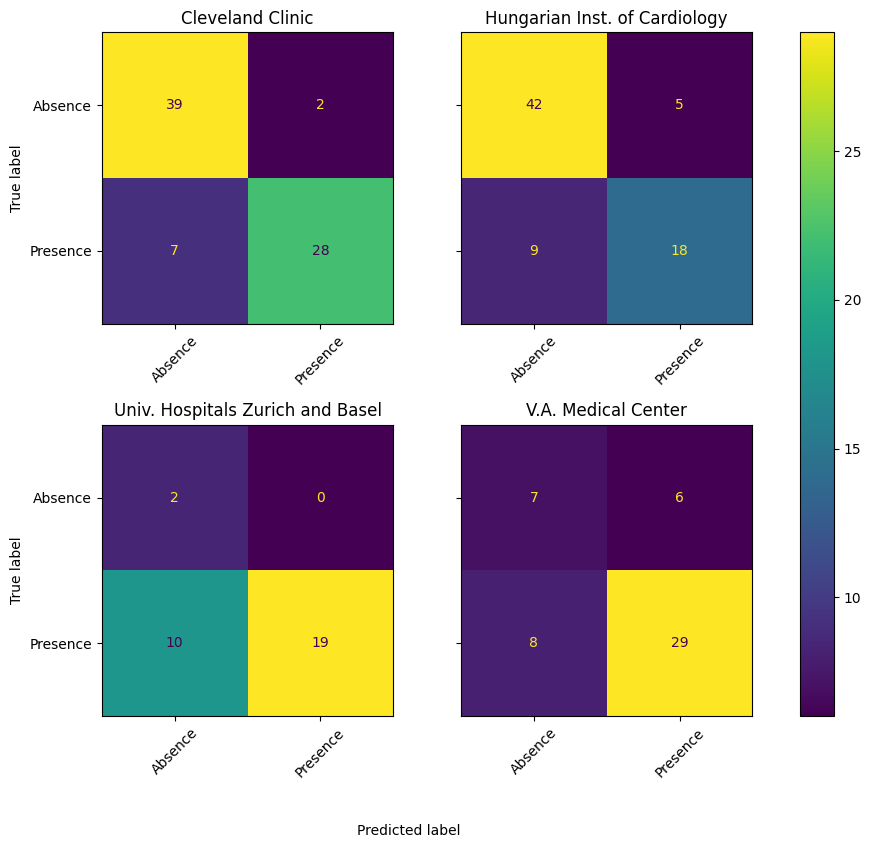

In [10]:
from matplotlib import pyplot as plt
from utils import plot_all_confusion_matrices

plot_all_confusion_matrices(confusion_matrices)
plt.show()

## Conclusions 🎉

💡 Using an Ensemble of all models, we have been able to _improve_ the results of our classifier on **all** the four datasets by _indirectly_ incorporating the knowledge gathered from each (non-public) dataset, independently!

And we did this by **never, ever** _seeing_ the true private data stored in each datasite!